In [24]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [25]:
df = pd.read_parquet("../data/df_step2.parquet")
embeddings_df = pd.read_parquet("../data/df_step3.it2.embeddingsDf.parquet")
df_final = pd.read_parquet("../data/df_step3.it2.dfFinal.parquet")

In [26]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 497975 entries, 0 to 551442
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   Lyrics                          497975 non-null  object
 1   Length                          497975 non-null  object
 2   emotion                         497975 non-null  object
 3   Genre                           497975 non-null  object
 4   Key                             497975 non-null  object
 5   Tempo                           497975 non-null  object
 6   Loudness                        497975 non-null  object
 7   Time signature                  497975 non-null  object
 8   Explicit                        497975 non-null  object
 9   Popularity                      497975 non-null  object
 10  Energy                          497975 non-null  object
 11  Danceability                    497975 non-null  object
 12  Positiveness                    497

# Preprocesamiento 2

### Embeddings

In [27]:
# ONLY COLAB
# # use a sample of the dataset, or the full dataset
# useASample = True
# if (useASample):
#     df = df.sample(n=10000, random_state=42)

In [28]:
# ONLY COLAB
# # Instanciás el modelo preentrenado
# model = SentenceTransformer('all-MiniLM-L6-v2')

# # Transformar todas las columnas a embeddings, excepto la variable objetivo 'emotion'
# embeddings = model.encode(df.drop(columns=['emotion']).astype(str).to_numpy().tolist(), convert_to_tensor=False, show_progress_bar=True)

# # Convertís los embeddings a DataFrame
# embeddings_df = pd.DataFrame(embeddings, columns=[f'emb_{i}' for i in range(embeddings.shape[1])])

# # Reseteás el índice de ambos DataFrames
# df = df.reset_index(drop=True)
# embeddings_df = embeddings_df.reset_index(drop=True)

# # Concatenás solo los embeddings y la variable objetivo 'emotion'
# df_final = pd.concat([embeddings_df, df['emotion'].reset_index(drop=True)], axis=1)

# # Mostrás el resultado
# df_final.head()

### PCA sobre embeddings

In [29]:
pca = PCA(random_state=42)
embeddings_pca = pca.fit_transform(embeddings_df)

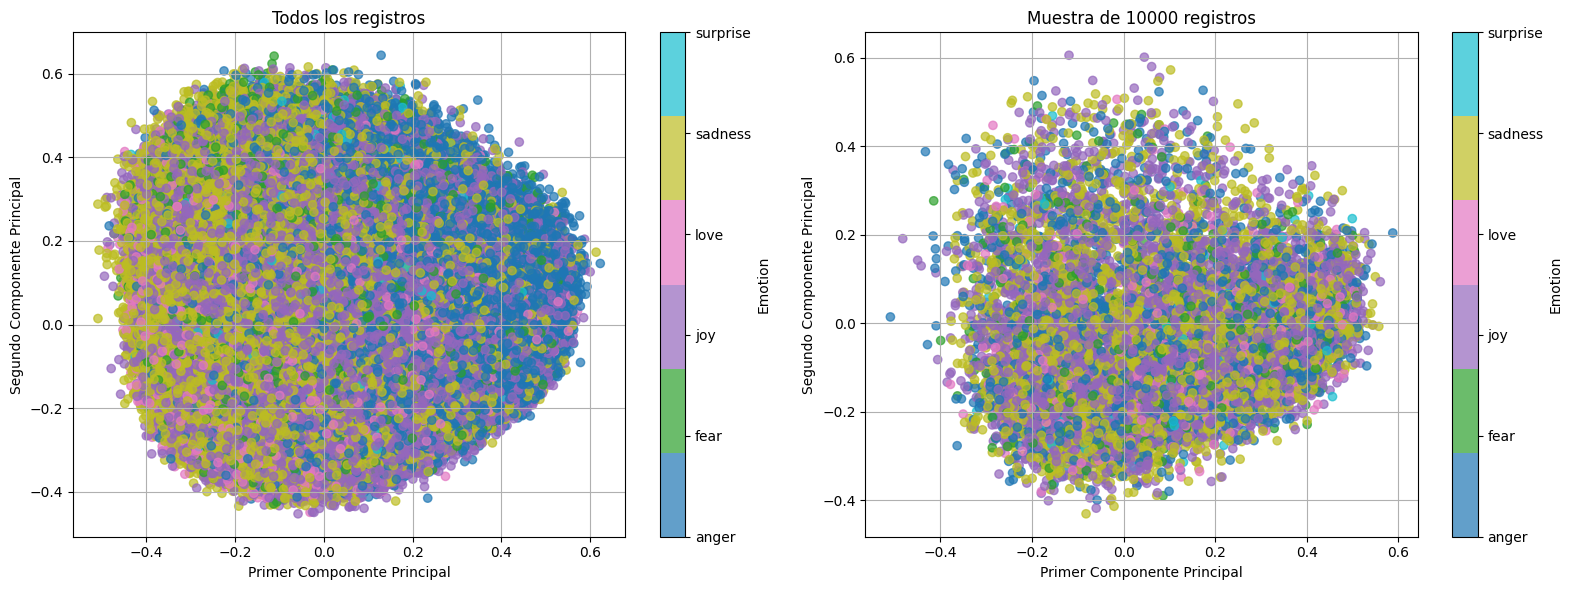

In [30]:
# Función para graficar dispersión de PCA
def plot_pca_scatter(embeddings, df_plot, title):
    emotions = df_plot['emotion'].astype('category')
    codes = emotions.cat.codes
    labels = emotions.cat.categories
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=codes, cmap=plt.get_cmap('tab10', len(labels)), alpha=0.7)
    plt.xlabel('Primer Componente Principal')
    plt.ylabel('Segundo Componente Principal')
    plt.title(title)
    cb = plt.colorbar(scatter, ticks=range(len(labels)))
    cb.ax.set_yticklabels(labels)
    cb.set_label('Emotion')
    plt.grid(True)

# Preparar datos para ambos gráficos
sample_size = 10000
if len(df) > sample_size:
    df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    embeddings_pca_sample = embeddings_pca[df_sample.index]
else:
    df_sample = df.reset_index(drop=True)
    embeddings_pca_sample = embeddings_pca

# Mostrar ambos gráficos uno al lado del otro
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_pca_scatter(embeddings_pca, df.reset_index(drop=True), 'Todos los registros')
plt.subplot(1, 2, 2)
plot_pca_scatter(embeddings_pca_sample, df_sample, f'Muestra de {len(df_sample)} registros')
plt.tight_layout()
plt.show()

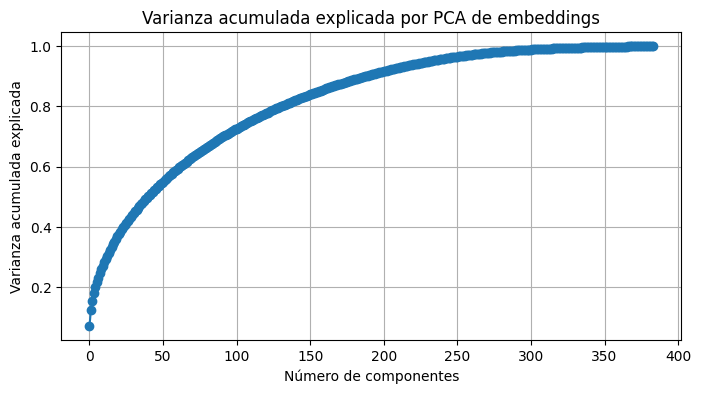

In [31]:
# Plot de la varianza acumulada
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada explicada')
plt.title('Varianza acumulada explicada por PCA de embeddings')
plt.grid(True)
plt.show()

In [32]:
# Tabla de número de componentes necesarios para explicar distintos porcentajes de varianza
porcentajes = [0.75, 0.80, 0.85, 0.90, 0.95]
componentes = [np.argmax(np.cumsum(pca.explained_variance_ratio_) >= p) + 1 for p in porcentajes]
tabla = pd.DataFrame({
    'Porcentaje de varianza': [f'{int(p*100)}%' for p in porcentajes],
    'N° de componentes': componentes
})
tabla

,Porcentaje de varianza,N° de componentes
0,75%,110
1,80%,132
2,85%,157
3,90%,189
4,95%,232


In [33]:
pca_final = PCA(n_components=0.80, random_state=42)
embeddings_pca_final = pca_final.fit_transform(embeddings_df)

### Normalizar los embeddings PCA

In [35]:
# Normalizamos los embeddings PCA
scaler = MinMaxScaler()

embeddings_pca_final = scaler.fit_transform(embeddings_pca_final)

# Convertimos a DataFrame
embeddings_pca_final_df = pd.DataFrame(embeddings_pca_final,
                                                    columns=[f'emb_pca_{i}' for i in range(embeddings_pca_final.shape[1])])

# Concatenamos al dataset original
df_final_pca = pd.concat([embeddings_pca_final_df, df['emotion'].reset_index(drop=True)], axis=1)

In [36]:
# Guardar el DataFrame modificado en formato eficiente
df_final_pca.to_parquet("../data/df_step3.parquet")

En el proximo paso se comenzará con los entrenamiento de los modelos RF y KNN